In [ ]:
# Music-Mood Classifier (CSI 4106 - Project - Group 29)
# Afrah Ali - 300049798 - aali179@uottawa.ca 
# Ribhav Khosla - 300087647 - rkhos052@uottawa.ca 
# Zain Malik - 300071476 - zmali081@uottawa.ca 

In [3]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 42
tf.random.set_seed(SEED)
# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 17300), started 0:00:44 ago. (Use '!kill 17300' to kill it.)

Dataframe shape:  (260, 16)
['acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
Class distribution:
happy        65
sad          65
stressful    65
calm         65
Name: mood, dtype: int64
          track_name               artist                track_id  \
0        Upside Down         Jack Johnson  6shRGWCtBUOPFLFTTqXZIC   
1        Someone New               Hozier  0efT4YKQLQx2YHbp6vgRX8   
2       Little Talks  Of Monsters and Men  3a2tuvXCHbW5nuUckuHkKT   
3    Heart's Content       Brandi Carlile  0pegFWSUOTiG0sLVEfxtvA   
4     Sunday Morning             Maroon 5  4T5cqerbDXueYSVfXkIITo   
..               ...                  ...                     ...   
255    am ersten Tag       Hugo Vanbrooke  2gwhISMkdlhEqEP60P93Z1   
256    Amour naturel       Massimo Pavoni  39bh8hsTP2ZBQWH0E308rT   
257      Dawn Of Day          Sarah Seing  635M2GuMSoVunGBe7D7vWz   
258         Lumino

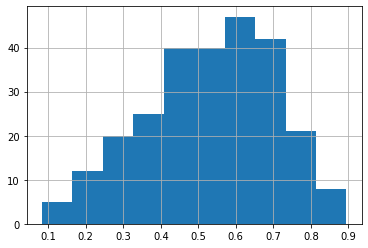

In [5]:
# load the dataset
df = pd.read_csv('dataset.csv')
# print the dimensionality of the dataframe (1)
print('Dataframe shape: ', df.shape)
# print the names of the columns that can be used as features when training the machine learning model (1)
# dropping non-features
dataset = df.drop(columns=['mood', 'track_name', 'artist', 'track_id'])
columns = list(dataset.columns)
print(columns)

print("Class distribution:")
print(df['mood'].value_counts())

#Label encoder
le = LabelEncoder()
df['mood_N'] = le.fit_transform(df['mood'])
df = df.drop(columns=['mood'])
df = df.rename(columns={'mood_N': 'mood'})
print(df)

# split dataset for training and testing
target = df['mood']
print(target)
# Set Training and Testing Data as 8:2
x_train, x_test, y_train, y_test = train_test_split(dataset , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)
# Show the Training and Testing Data
print('Shape of training feature:', x_train.shape)
print('Shape of testing feature:', x_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

# By analysing the features, the feature that has the closest rough approximation of Gaussian distribution is the danceability feature
dataset["danceability"].hist()

# identify features that represent a notable correlation (i.e., either positive or negative correlation below or above -0.5 and 0.5) (3)
# TODO: possibly drop correlated features
print("Features with notable correlation: ")
all_corr = dataset.corr()
for i in range(len(all_corr)):
    for j in range(i):
        if all_corr.iloc[i, j] > 0.5 or all_corr.iloc[i, j] < -0.5:
            print(str(all_corr.columns[i]) + " and " + str(all_corr.columns[j]) + " = " + str(all_corr.iloc[i, j]))

# Comparing energy values across moods
print("Mean energy for happy songs:", df.loc[df['mood'] == 'happy']['energy'].mean())
print("Mean energy for calm songs:", df.loc[df['mood'] == 'calm']['energy'].mean())
print("Mean energy for stressful songs:", df.loc[df['mood'] == 'stressful']['energy'].mean())
print("Mean energy for sad songs:", df.loc[df['mood'] == 'sad']['energy'].mean())

# Proportional class distribution

print("Class distribution of train set: ", y_train.value_counts())
print("Class distribution of test set: ", y_test.value_counts())

In [48]:
# specify the batch size hyperparameter. You can experiment with different batch sizes
batch_size = 16

# specify the model input with the required shape 
inputs = keras.Input(shape=(12,)) # 12 features

# The shared layers
intermediate = layers.Dense(256, activation='relu')(inputs)
outputs = layers.Dense(4, activation='softmax', name='MoodOutput')(intermediate)

# create the model with the required input and the outputs.
model = keras.Model(inputs=inputs, outputs=outputs)

# print the model summary
print(model.summary())

# Instantiate the optimizer with the learning rate
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)

# compile the model with the optimizer, loss and the metrics
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ModelCheckpoint
# monitor validation loss and save the best model weights
checkpoints=keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(os.path.curdir, 'models'),
    monitor='accuracy',
    save_best_only=True,
    save_weights_only=False
)

# Initiallize TensorBoard
tensorboard=keras.callbacks.TensorBoard(
    log_dir=os.path.join(os.path.curdir, 'logs'),
)

# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
reduce_lr=keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

# fit the model with training and validation generators
model.fit(
    x=x_train,
    y= y_train,
    epochs=10,
    batch_size=batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    callbacks=[reduce_lr, checkpoints, tensorboard]
)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 12)]              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               3328      
_________________________________________________________________
MoodOutput (Dense)           (None, 4)                 1028      
Total params: 4,356
Trainable params: 4,356
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
13/13 [==============================] - 1s 34ms/step - loss: 3.6752 - accuracy: 0.2792
INFO:tensorflow:Assets written to: .\models\assets
Epoch 2/10
13/13 [==============================] - 0s 748us/step - loss: 1.8028 - accuracy: 0.3281
INFO:tensorflow:Assets written to: .\models\assets
Epoch 3/10
13/13 [==============================] - 0s 2ms/step - loss: 1.7393 -

In [49]:
# evaluate the trained model using the test generator
test_evaluation = model.evaluate(x_test, y_test, verbose=1)


2/2 [==============================] - 0s 3ms/step - loss: 1.1229 - accuracy: 0.5385


In [50]:
# generate predictions using the test generator
test_prediction = model.predict(x_test)
print(x_test)
test_prediction = np.argmax(test_prediction, axis=1)

# print the classification report for predicting mood
print(classification_report(y_test, test_prediction))



     acousticness  danceability   energy  instrumentalness  key  liveness  \
102      0.578000        0.6040  0.36600          0.000000    5    0.1330   
245      0.955000        0.0834  0.16300          0.974000    8    0.1100   
194      0.247000        0.2060  0.23100          0.850000   11    0.0968   
117      0.785000        0.4470  0.39300          0.000000    5    0.2800   
190      0.000716        0.3030  0.91300          0.227000   11    0.1130   
219      0.592000        0.3420  0.29400          0.674000    2    0.0944   
78       0.198000        0.5480  0.42000          0.000004    0    0.0899   
257      0.975000        0.3940  0.09980          0.931000    2    0.1120   
127      0.178000        0.3890  0.66500          0.000732    0    0.1160   
107      0.691000        0.3800  0.33900          0.000000    3    0.1200   
27       0.057000        0.6950  0.65600          0.000000    1    0.2670   
259      0.988000        0.3970  0.00375          0.957000    9    0.1150   